# Hemifield stimulation experiment

### This is an attempt to index by subject for easier group-wise analysis later

In [1]:
import os, json, pickle, sys
import nibabel as nb
from sklearn.preprocessing import normalize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# import hrf_estimation
import scipy.signal as signal
import scipy.stats as ss
import scipy.ndimage as ndimage

from joblib import Parallel, delayed

import nideconv as nd
import scipy.io as io
import csv
from prfpy.timecourse import sgfilter_predictions
import pathlib

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from linescanning.bin.utils.utils import get_base_dir, format_graph
base, place = get_base_dir()

base_dir = os.path.join(base, 'projects', 'ANAT_SEG-Raw')
model_dir = os.path.join(base_dir, 'derivatives', 'model_fitting')

pathlib.Path(model_dir).mkdir(parents=True, exist_ok=True)

/mnt/export/data1/projects/MicroFunc/Jurjen/programs/packages/prfpy/prfpy/model.py:3: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats.hemodynamic_models import spm_hrf, spm_time_derivative, spm_dispersion_derivative


In [2]:
# run_subjects = ['001', '005', '006']
run_subjects = ['003']
session = "ses-2"

TR = 0.105
deleted_first_timepoints = 38
deleted_last_timepoints = 38

initial_deleted_time = TR * deleted_first_timepoints

# Sample rate and desired cutoff frequencies (in Hz).
fs = 1/TR

hp=0.01
lp=8.0
butter_order = 3
sg_filter_length = 2001

data = []
onsets = []

# Create data frames per subject and run
########################################

for sub in run_subjects:

    print("\n------------------------------ processing {sub} ------------------------------".format(sub=f'sub-{sub}'))

    session_dir = os.path.join(base_dir, f'sub-{sub}', session, 'func')
    f = os.listdir(session_dir)
    nr_runs = []; [nr_runs.append(os.path.join(session_dir, r)) for r in f if "bold.mat" in r]

    if len(nr_runs) != 0:

        for run in range(1,len(nr_runs)+1):

            print(f"  dealing with run-{run}")

            sub_idx = run_subjects.index(sub)+1

            data_onsets = []
            df_onsets = os.path.join(session_dir, f'sub-{sub}_{session}_task-LR_run-{run}_events.tsv')
            with open(df_onsets) as f:
                timings = pd.read_csv(f, delimiter='\t')
                data_onsets.append(pd.DataFrame(timings))

            # TIMING STUFF
            ##############

            start_times = pd.DataFrame(data_onsets[0][(data_onsets[0]['response'] == 't') & (data_onsets[0]['trial_nr'] == 1) & (data_onsets[0]['phase'] == 0)][['onset']])

            onset_times = pd.DataFrame(data_onsets[0][(data_onsets[0]['event_type'] == 'stim') & (data_onsets[0]['condition'].notnull())][['onset', 'condition']]['onset'] - float(start_times['onset']))

            condition = pd.DataFrame(data_onsets[0][(data_onsets[0]['event_type'] == 'stim') & (data_onsets[0]['condition'].notnull())]['condition'])

            onset = np.concatenate((onset_times-(deleted_first_timepoints*TR), condition), axis=1)

            mixed_onsets2 = pd.DataFrame(onset, columns=['onset', 'event_type'])
            mixed_onsets2['subject'], mixed_onsets2['run'] = sub_idx, run
            mixed_onsets2 = mixed_onsets2.astype({"onset": float, "event_type": str})

            # mixed_onsets2.set_index(['subject', 'run', 'event_type'])

            onsets.append(mixed_onsets2)

            # TIME SERIES STUFF
            ###################

            # Load in datasets with tag "wcsmtSNR"
            ts_wcsmtSNR = io.loadmat(os.path.join(session_dir, f'sub-{sub}_{session}_task-LR_run-{run}_bold.mat'))['Data_wcsmtSNR']
            ts_complex = ts_wcsmtSNR
            ts_magnitude = np.abs(ts_wcsmtSNR)
            # print("  run-{run} has {vols} volumes".format(run=run, vols=ts_magnitude.shape[1]))
            
            # trim beginning and end 
            ts_corrected = ts_magnitude[:,deleted_first_timepoints:-deleted_last_timepoints]
            
            # filter data
            ts_filtered = sgfilter_predictions(ts_corrected, window_length=sg_filter_length, polyorder=3)

            # just doing z-scoring now.
            z_run_data = (ts_filtered-ts_filtered.mean(-1)[:,np.newaxis]) / ts_filtered.std(1)[:,np.newaxis]
            # or percent signal change?
            # z_run_data = [100*(rd-rd.mean(-1)[:,np.newaxis]) / rd.mean(1)[:,np.newaxis] for rd in ts_corrected]

            vox_cols = [f'vox {x}' for x in range(z_run_data.shape[0])]

            mixed_data2 = pd.DataFrame(z_run_data.T, columns=vox_cols)
            mixed_data2['subject'], mixed_data2['run'], mixed_data2['t'] = sub_idx, run, list(TR*np.arange(z_run_data.shape[-1]))

            data.append(mixed_data2)
            onsets.append(mixed_onsets2)

onsets = pd.concat(onsets).set_index(['subject', 'run', 'event_type']); onsets.to_csv(os.path.join(model_dir, 'onsets.csv'))
data = pd.concat(data).set_index(['subject', 'run', 't']); data.to_csv(os.path.join(model_dir, 'timecourses.csv'))


------------------------------ processing sub-001 ------------------------------
  dealing with run-1
  dealing with run-2
  dealing with run-3
  dealing with run-4


In [107]:
tmp = onsets.reset_index()
print(tmp.head())
left = tmp[(tmp['subject'] == 1) & (tmp['run'] == 1) & (tmp['event_type'] == 'right')]
left.shape

   subject  run event_type      onset
0        1    1      right  23.472308
1        1    1       left  27.597360
2        1    1      right  31.430757
3        1    1      right  45.872664
4        1    1      right  49.814391


(40, 4)

In [3]:
# Model fitting
###############
print("\nPerform model fitting in nideconv")
g_model = nd.GroupResponseFitter(data,
                                 onsets,
                                 input_sample_rate=1.0/TR,
                                 concatenate_runs=False,
                                 confounds=None, add_intercept=False)

# Add event for each condition
cond = onsets.reset_index().event_type.unique()
[g_model.add_event(i,
                  basis_set='fourier',
                  n_regressors=9,
                  interval=[0, 20]) for i in cond]

g_model.fit()


Perform model fitting in nideconv


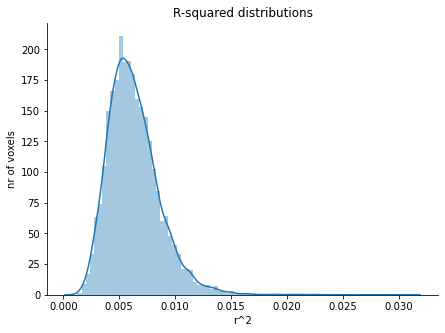

In [4]:
plt.figure(figsize=(7,5))
sns.distplot(g_model.get_rsq(),
            label='0 model',
            bins=80)

format_graph('r^2',
            'nr of voxels',
            axis=False,
            leg=False,
            box=False,
            title='R-squared distributions',
            out=None)

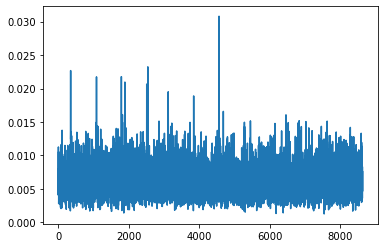

In [5]:
plt.plot(g_model.get_rsq().to_numpy().ravel())

In [6]:
g_model.get_conditionwise_timecourses()

vox 0     vox 1     vox 2     vox 3  \
event type covariate time                                               
left       intercept 0.00000  -0.012028 -0.024044  0.021344  0.001856   
                     0.00525  -0.011952 -0.024093  0.021351  0.001867   
                     0.01050  -0.011876 -0.024141  0.021358  0.001878   
                     0.01575  -0.011801 -0.024190  0.021364  0.001890   
                     0.02100  -0.011724 -0.024238  0.021371  0.001902   
...                                 ...       ...       ...       ...   
right      intercept 19.92375  0.033600 -0.028525  0.002018 -0.017101   
                     19.92900  0.033593 -0.028595  0.002027 -0.017154   
                     19.93425  0.033585 -0.028664  0.002036 -0.017207   
                     19.93950  0.033576 -0.028733  0.002045 -0.017259   
                     19.94475  0.033566 -0.028802  0.002054 -0.017311   

                                  vox 4     vox 5     vox 6     vox 7  \
event type covariate time                                               
left       intercept 0.00000  -0.013922  0.009884  0.026698 -0.008158   
                     0.00525  -0.013827  0.009880  0.026725 -0.008158   
                     0.01050  -0.013731  0.009876  0.026752 -0.008157   
                     0.01575  -0.013635  0.009872  0.026779 -0.008156   
                     0.02100  -0.013538  0.009869  0.026806 -0.008156   
...                                 ...       ...       ...       ...   
right      intercept 19.92375 -0.003466  0.013367  0.016014 -0.018435   
                     19.92900 -0.003341  0.013480  0.016079 -0.018385   
                     19.93425 -0.003216  0.013593  0.016143 -0.018335   
                     19.93950 -0.003091  0.013706  0.016208 -0.018285   
                     19.94475 -0.002966  0.013818  0.016273 -0.018235   

                                  vox 8     vox 9  ...   vox 710   vox 711  \
event type covariate time                          ...                       
left       intercept 0.00000   0.004730  0.006678  ...  0.014442 -0.016869   
                     0.00525   0.004702  0.006733  ...  0.014419 -0.016854   
                     0.01050   0.004674  0.006788  ...  0.014396 -0.016839   
                     0.01575   0.004646  0.006843  ...  0.014372 -0.016824   
                     0.02100   0.004618  0.006898  ...  0.014349 -0.016808   
...                                 ...       ...  ...       ...       ...   
right      intercept 19.92375 -0.002718 -0.011113  ...  0.005781 -0.005062   
                     19.92900 -0.002758 -0.011185  ...  0.005884 -0.004978   
                     19.93425 -0.002797 -0.011257  ...  0.005986 -0.004895   
                     19.93950 -0.002838 -0.011329  ...  0.006088 -0.004812   
                     19.94475 -0.002878 -0.011401  ...  0.006189 -0.004729   

                                vox 712   vox 713   vox 714   vox 715  \
event type covariate time                                               
left       intercept 0.00000  -0.016287  0.004181 -0.001218  0.009475   
                     0.00525  -0.016138  0.003943 -0.001139  0.009563   
                     0.01050  -0.015989  0.003706 -0.001061  0.009651   
                     0.01575  -0.015840  0.003469 -0.000983  0.009740   
                     0.02100  -0.015690  0.003231 -0.000904  0.009828   
...                                 ...       ...       ...       ...   
right      intercept 19.92375  0.002189 -0.019361 -0.005525 -0.017426   
                     19.92900  0.002267 -0.019380 -0.005613 -0.017478   
                     19.93425  0.002345 -0.019399 -0.005701 -0.017529   
                     19.93950  0.002422 -0.019418 -0.005790 -0.017581   
                     19.94475  0.002499 -0.019437 -0.005878 -0.017632   

                                vox 716   vox 717   vox 718   vox 719  
event type covariate time                                              
left       intercept 0.00

In [7]:
# plt.figure(figsize=(24,9))
# plt.imshow(g_model.get_conditionwise_timecourses().T, aspect=1/3)
# plt.gca().set_xlabel('time')
# plt.gca().set_ylabel('voxels')

In [8]:
# cond = g_model.get_conditionwise_timecourses()
# fig = plt.figure(figsize=(20,10))
# gs1 = gridspec.GridSpec(1, 2)
# gs1.update(wspace=0.2, hspace=0) # set the spacing between axes.

# step = 0

# for i in ['left', 'right']:


#     g = fig.add_subplot(gs1[step])
#     g.imshow(cond.loc[i].T, aspect=1/4)
#     format_graph('time', 'voxels', axis=False, leg=False, box=False, title=f'timecourses {i} hemisphere', out=None)

#     step += 1

# plt.savefig(os.path.join(base_dir, 'code', 'figures', 'hrfs', 'timecourses.png'))

In [9]:
group = g_model.get_conditionwise_timecourses()
group

vox 0     vox 1     vox 2     vox 3  \
event type covariate time                                               
left       intercept 0.00000  -0.012028 -0.024044  0.021344  0.001856   
                     0.00525  -0.011952 -0.024093  0.021351  0.001867   
                     0.01050  -0.011876 -0.024141  0.021358  0.001878   
                     0.01575  -0.011801 -0.024190  0.021364  0.001890   
                     0.02100  -0.011724 -0.024238  0.021371  0.001902   
...                                 ...       ...       ...       ...   
right      intercept 19.92375  0.033600 -0.028525  0.002018 -0.017101   
                     19.92900  0.033593 -0.028595  0.002027 -0.017154   
                     19.93425  0.033585 -0.028664  0.002036 -0.017207   
                     19.93950  0.033576 -0.028733  0.002045 -0.017259   
                     19.94475  0.033566 -0.028802  0.002054 -0.017311   

                                  vox 4     vox 5     vox 6     vox 7  \
event type covariate time                                               
left       intercept 0.00000  -0.013922  0.009884  0.026698 -0.008158   
                     0.00525  -0.013827  0.009880  0.026725 -0.008158   
                     0.01050  -0.013731  0.009876  0.026752 -0.008157   
                     0.01575  -0.013635  0.009872  0.026779 -0.008156   
                     0.02100  -0.013538  0.009869  0.026806 -0.008156   
...                                 ...       ...       ...       ...   
right      intercept 19.92375 -0.003466  0.013367  0.016014 -0.018435   
                     19.92900 -0.003341  0.013480  0.016079 -0.018385   
                     19.93425 -0.003216  0.013593  0.016143 -0.018335   
                     19.93950 -0.003091  0.013706  0.016208 -0.018285   
                     19.94475 -0.002966  0.013818  0.016273 -0.018235   

                                  vox 8     vox 9  ...   vox 710   vox 711  \
event type covariate time                          ...                       
left       intercept 0.00000   0.004730  0.006678  ...  0.014442 -0.016869   
                     0.00525   0.004702  0.006733  ...  0.014419 -0.016854   
                     0.01050   0.004674  0.006788  ...  0.014396 -0.016839   
                     0.01575   0.004646  0.006843  ...  0.014372 -0.016824   
                     0.02100   0.004618  0.006898  ...  0.014349 -0.016808   
...                                 ...       ...  ...       ...       ...   
right      intercept 19.92375 -0.002718 -0.011113  ...  0.005781 -0.005062   
                     19.92900 -0.002758 -0.011185  ...  0.005884 -0.004978   
                     19.93425 -0.002797 -0.011257  ...  0.005986 -0.004895   
                     19.93950 -0.002838 -0.011329  ...  0.006088 -0.004812   
                     19.94475 -0.002878 -0.011401  ...  0.006189 -0.004729   

                                vox 712   vox 713   vox 714   vox 715  \
event type covariate time                                               
left       intercept 0.00000  -0.016287  0.004181 -0.001218  0.009475   
                     0.00525  -0.016138  0.003943 -0.001139  0.009563   
                     0.01050  -0.015989  0.003706 -0.001061  0.009651   
                     0.01575  -0.015840  0.003469 -0.000983  0.009740   
                     0.02100  -0.015690  0.003231 -0.000904  0.009828   
...                                 ...       ...       ...       ...   
right      intercept 19.92375  0.002189 -0.019361 -0.005525 -0.017426   
                     19.92900  0.002267 -0.019380 -0.005613 -0.017478   
                     19.93425  0.002345 -0.019399 -0.005701 -0.017529   
                     19.93950  0.002422 -0.019418 -0.005790 -0.017581   
                     19.94475  0.002499 -0.019437 -0.005878 -0.017632   

                                vox 716   vox 717   vox 718   vox 719  
event type covariate time                                              
left       intercept 0.00

In [10]:
# fig = plt.figure(figsize=(20,5))
# gs1 = gridspec.GridSpec(1, 2)
# gs1.update(wspace=0.2, hspace=0) # set the spacing between axes.

# g = fig.add_subplot(gs1[0])
# step = 0
# for x in np.arange(350,360,1):
#     g_model.get_conditionwise_timecourses().iloc[:, x]['left'].droplevel([0]).plot(fig=g)
#     format_graph('time', 'Delta BOLD SI (%)', axis=False, leg=False, box=False, title='HRFs left hemi stimulation', out=None)

# g = fig.add_subplot(gs1[1])
# step = 0
# for x in np.arange(350,360,1):
#     g_model.get_conditionwise_timecourses().iloc[:, x]['right'].droplevel([0]).plot(fig=g)
#     format_graph('time', 'Delta BOLD SI (%)', axis=False, leg=False, box=False, title='HRFs right hemi stimulation', out=None)

# plt.savefig(os.path.join(base_dir, 'code', 'figures', 'hrfs', 'hrfs.png'))

In [11]:
# import matplotlib.patches as patches

# cond = g_model.get_conditionwise_timecourses()
# fig = plt.figure(figsize=(15,10))
# gs1 = gridspec.GridSpec(2, 2)
# gs1.update(wspace=0.2, hspace=0.3) # set the spacing between axes.

# step = 0

# for i in ['left', 'right']:


#     g = fig.add_subplot(gs1[step])
#     ax = g.imshow(cond.loc[i].T, aspect=1/4)
#     rect = patches.Rectangle((0,350),cond.loc[i].shape[0],10,linewidth=1,edgecolor='#FFFFFF',facecolor='none')
#     g.add_patch(rect)
#     format_graph('time', 'voxels', axis=False, leg=False, box=False, title=f'timecourses {i} hemisphere stimulation', out=None)
#     fig.colorbar(ax, ax=g)
#     step += 1

#     g = fig.add_subplot(gs1[step])
#     for x in np.arange(350,360,1):
#         g_model.get_conditionwise_timecourses().iloc[:, x][i].droplevel([0]).plot(fig=g)
#         format_graph('time', 'Delta BOLD SI (%)', axis=False, leg=False, box=False, title=f'HRFs {i} hemi stimulation', out=None)

#     step += 1

# # plt.show()



# plt.savefig(os.path.join(base_dir, 'code', 'figures', 'hrfs', 'hrf_and_timecourses.png'))



In [12]:
subj = g_model.get_subjectwise_timecourses()
subj.shape


(22800, 720)

In [13]:
# subj_001 = subj.reset_index()
# subj_001 = subj_001[(subj_001['subject'] == 1)]
# # subj_001 = subj_001 = subj.reset_index()
# subj_001 = subj_001.set_index(['subject', 'event type', 'covariate', 'time'])
# subj_001

In [14]:
from linescanning.bin.utils.utils import get_linerange 
orient = ['wm', 'wm', 'pial']
hemi = 'left'

# sub = 1

#  #---------------------------------------------------------------------------------------------------------------------------------------------
# # This stuff calculates the voxels of the line that cover the cortical band based on the thickness created with pycortex
# try:
#     info_file = os.path.join(base_dir, 'derivatives', 'pycortex', f'sub-00{sub}', 'line_pycortex.csv')
#     try:
#         from linescanning.bin.utils.utils import get_composite
#         info_df = get_composite(info_file)
#     except:
#         raise FileNotFoundError

#     info_df = info_df.reset_index()
#     vert = int(info_df[(info_df['hemi'] == hemi) & (info_df['parameter'] == "vertex")]['value'].values)

#     r = get_linerange(os.path.join(base_dir, 'derivatives', 'pycortex', f'sub-00{sub}', 'surface-info', 'thickness.npz'), hemi, vert, orient[sub-1])
# except:
#     r = [355, 360]

# print(r)
# len(np.arange(r[0],r[1]+1,1))

In [45]:
from colour import Color

red = Color("red")
colors = list(red.range_to(Color("blue"),10))
print(colors)
reversed_list = colors[::-1]
print(reversed_list)


[<Color red>, <Color #ff7100>, <Color #ffe300>, <Color #af0>, <Color #39ff00>, <Color #00ff39>, <Color #0fa>, <Color #00e3ff>, <Color #0071ff>, <Color blue>]
[<Color blue>, <Color #0071ff>, <Color #00e3ff>, <Color #0fa>, <Color #00ff39>, <Color #39ff00>, <Color #af0>, <Color #ffe300>, <Color #ff7100>, <Color red>]


In [24]:
plt.figure(figsize=(7,15))
fig, axs = plt.subplots(ncols=len(run_subjects), nrows=2)
subj = g_model.get_subjectwise_timecourses()

for sub in range(1,len(run_subjects)+1):

    #---------------------------------------------------------------------------------------------------------------------------------------------
    # This stuff calculates the voxels of the line that cover the cortical band based on the thickness created with pycortex
    # If that doesn't succeed it defaults to [355,360]
    try:
        info_file = os.path.join(base_dir, 'derivatives', 'pycortex', f'sub-00{sub}', 'line_pycortex.csv')
        try:
            from linescanning.bin.utils.utils import get_composite
            info_df = get_composite(info_file)
        except:
            raise FileNotFoundError

        info_df = info_df.reset_index()
        vert = int(info_df[(info_df['hemi'] == hemi) & (info_df['parameter'] == "vertex")]['value'].values)

        r = get_linerange(os.path.join(base_dir, 'derivatives', 'pycortex', f'sub-00{sub}', 'surface-info', 'thickness.npz'), hemi, vert, orient[sub-1])
    except:
        r = [355, 360]

    nr_vox = len(np.arange(r[0],r[1]+1,1))
    print(f"  {nr_vox} cover the cortical band")

    #---------------------------------------------------------------------------------------------------------------------------------------------
    # Loop through the dataframe    
    tmp = subj.reset_index()
    tmp = tmp[(tmp['subject'] == sub)]
    # subj_001 = subj_001 = subj.reset_index()
    tmp = tmp.set_index(['subject', 'event type', 'covariate', 'time'])

    for i in ['left', 'right']:

        g = fig.add_subplot(len(run_subjects),2,step)
        vox_nr = 0
        for x in np.arange(r[0],r[1]+1,1):
            tmp.droplevel([0]).iloc[:, x][i].plot(fig=g, sharex=True, color=rgb[vox_nr])
            format_graph('time', 'Delta BOLD SI (%)', axis=False, leg=False, box=False, title=f'HRFs {i} hemi stimulation', out=None)

        step += 1
        vox_nr += 1

plt.tight_layout()

fig.axes.get_xaxis().set_ticks([])
# plt.savefig(os.path.join(base_dir, 'code', 'figures', 'hrfs', 'hrf_and_timecourses_singlesub.png'))


  line first hits the wm-boundary: upper bound = pial; lower bound = wm
  5 voxels cover the cortical band
  6 voxels cover the cortical band
  line first hits the pial-boundary: upper bound = wm; lower bound = pial
  11 voxels cover the cortical band


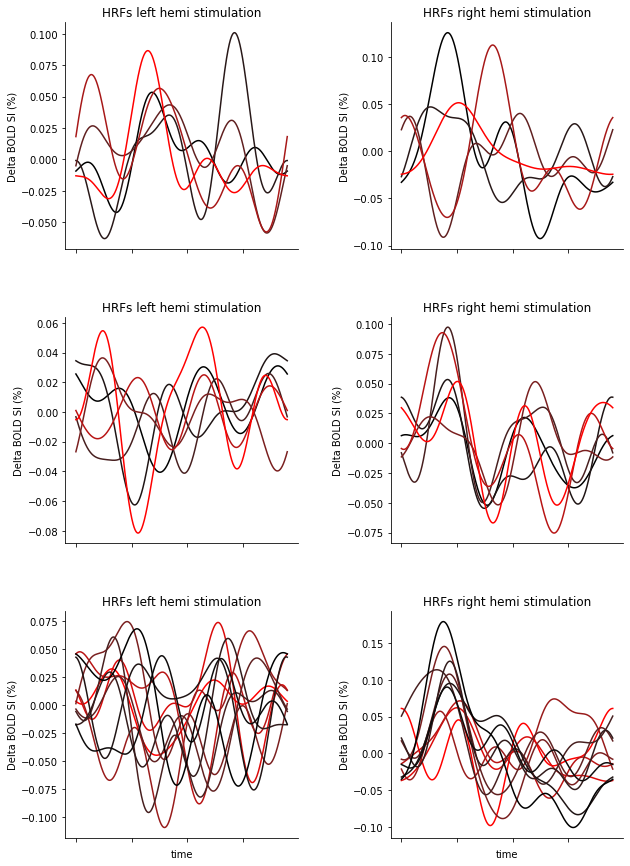

In [108]:
from colour import Color
from linescanning.bin.utils.utils import get_linerange

orient = ['wm', 'wm', 'pial']
hemi = 'left'
black = Color("black")
white = Color("red")

fig = plt.figure(figsize=(10,15))
gs1 = gridspec.GridSpec(len(run_subjects),2)
gs1.update(wspace=0.4, hspace=0.3) # set the spacing between axes.
subj = g_model.get_subjectwise_timecourses()

step = 0

for sub in range(1,len(run_subjects)+1):

    #---------------------------------------------------------------------------------------------------------------------------------------------
    # This stuff calculates the voxels of the line that cover the cortical band based on the thickness created with pycortex
    # If that doesn't succeed it defaults to [355,360]
    try:
        info_file = os.path.join(base_dir, 'derivatives', 'pycortex', f'sub-00{sub}', 'line_pycortex.csv')
        try:
            from linescanning.bin.utils.utils import get_composite
            info_df = get_composite(info_file)
        except:
            raise FileNotFoundError

        info_df = info_df.reset_index()
        vert = int(info_df[(info_df['hemi'] == hemi) & (info_df['parameter'] == "vertex")]['value'].values)

        r = get_linerange(os.path.join(base_dir, 'derivatives', 'pycortex', f'sub-00{sub}', 'surface-info', 'thickness.npz'), hemi, vert, orient[sub-1])
    except:
        r = [355, 360]

    nr_vox = len(np.arange(r[0],r[1]+1,1))
    colors = list(black.range_to(white, nr_vox))

    # invert gradient if orient == pial
    if orient[sub-1] == "pial":
        colors.reverse()

    print(f"  {nr_vox} voxels cover the cortical band")

    #---------------------------------------------------------------------------------------------------------------------------------------------
    # Loop through the dataframe    
    tmp = subj.reset_index()
    tmp = tmp[(tmp['subject'] == sub)]
    # subj_001 = subj_001 = subj.reset_index()
    tmp = tmp.set_index(['subject', 'event type', 'covariate', 'time'])

    
    for i in ['left', 'right']:
        
        vox_nr = 0
        g = fig.add_subplot(gs1[step])
        for x in np.arange(r[0],r[1]+1,1):
            tmp.droplevel([0]).iloc[:, x][i].plot(fig=g, sharex=True, color=colors[vox_nr].hex)
            format_graph('time', 'Delta BOLD SI (%)', axis=False, leg=False, box=False, title=f'HRFs {i} hemi stimulation', out=None)
            vox_nr += 1
        g.axes.xaxis.set_ticklabels([])

        step += 1
        

# fig.axes.get_xaxis().set_ticks([])
# plt.savefig(os.path.join(base_dir, 'code', 'figures', 'hrfs', 'hrf_and_timecourses_singlesub.png'))


In [79]:
import colorsys

color = []
for i in range(10):
    rgb = colorsys.hsv_to_rgb(i / 300., 1.0, 1.0)
    print(i, [round(255*x) for x in rgb])
    color.append([round(255*x) for x in rgb])

color.reverse()

0 [255, 0, 0]
1 [255, 5, 0]
2 [255, 10, 0]
3 [255, 15, 0]
4 [255, 20, 0]
5 [255, 25, 0]
6 [255, 31, 0]
7 [255, 36, 0]
8 [255, 41, 0]
9 [255, 46, 0]


In [4]:
from colour import Color
from linescanning.bin.utils.utils import get_linerange

orient = ['wm', 'wm', 'pial']
hemi = 'left'
black = Color("black")
white = Color("red")

fig = plt.figure(figsize=(20,20))
gs1 = gridspec.GridSpec(len(run_subjects),4)
gs1.update(wspace=0.4, hspace=0.3) # set the spacing between axes.
subj = g_model.get_subjectwise_timecourses()

step = 0

for sub in range(1,len(run_subjects)+1):

    #---------------------------------------------------------------------------------------------------------------------------------------------
    # This stuff calculates the voxels of the line that cover the cortical band based on the thickness created with pycortex
    # If that doesn't succeed it defaults to [355,360]
    try:
        info_file = os.path.join(base_dir, 'derivatives', 'pycortex', f'sub-00{sub}', 'line_pycortex.csv')
        try:
            from linescanning.bin.utils.utils import get_composite
            info_df = get_composite(info_file)
        except:
            raise FileNotFoundError

        info_df = info_df.reset_index()
        vert = int(info_df[(info_df['hemi'] == hemi) & (info_df['parameter'] == "vertex")]['value'].values)

        r = get_linerange(os.path.join(base_dir, 'derivatives', 'pycortex', f'sub-00{sub}', 'surface-info', 'thickness.npz'), hemi, vert, orient[sub-1])
    except:
        r = [355, 360]

    nr_vox = len(np.arange(r[0],r[1]+1,1))
    colors = list(black.range_to(white, nr_vox))

    # invert gradient if orient == pial
    if orient[sub-1] == "wm":
        colors.reverse()
    
    print(f"  range = [{r}]")
    print(f"  {nr_vox} voxels cover the cortical band")

    #---------------------------------------------------------------------------------------------------------------------------------------------
    # Loop through the dataframe    
    tmp = subj.reset_index()
    tmp = tmp[(tmp['subject'] == sub)]
    # subj_001 = subj_001 = subj.reset_index()
    tmp = tmp.set_index(['subject', 'event type', 'covariate', 'time'])

    
    for i in ['left', 'right']:

        if i == "right":
            colors.reverse()
            
        vox_nr = 0
        g = fig.add_subplot(gs1[step])
        max = []
        for x in np.arange(r[0],r[1]+1,1):
            tmp.droplevel([0]).iloc[:, x][i].plot(fig=g, sharex=True, color=colors[vox_nr].hex)
            format_graph('time', 'Delta BOLD SI (%)', axis=False, leg=False, box=False, title=None, out=None)
            vox_nr += 1

            max.append(np.amax(tmp.droplevel([0]).iloc[:, x][i]))
        
        
        g.axes.xaxis.set_ticklabels([])

        step += 1

        a = fig.add_subplot(gs1[step])
        from scipy.interpolate import make_interp_spline
        from scipy.stats import sem
        from linescanning.bin.utils.utils import errorfill

        x_new = np.linspace(1,nr_vox,50)
        a_BSpline = make_interp_spline(list(np.arange(0,nr_vox,1)),max)
        y_new = a_BSpline(x_new)
        err = sem(y_new)
        # a.plot(x_new, y_new)
        errorfill(x_new, y_new, err, color='#808080', alpha_fill=0.2, ax=a)

        format_graph('layers', 'Delta BOLD SI (%  )', axis=False, leg=False, box=False, title=None, out=None)
        a.axes.xaxis.set_ticklabels([])
        step += 1
        

# fig.axes.get_xaxis().set_ticks([])
# plt.savefig(os.path.join(base_dir, 'code', 'figures', 'hrfs', 'hrf_and_timecourses_and_maxampl_singlesub2.png'), transparent=True)


AssertionError: Level event type not in index

  line first hits the wm-boundary: upper bound = pial; lower bound = wm
  5 voxels cover the cortical band
  6 voxels cover the cortical band
  line first hits the pial-boundary: upper bound = wm; lower bound = pial
  11 voxels cover the cortical band


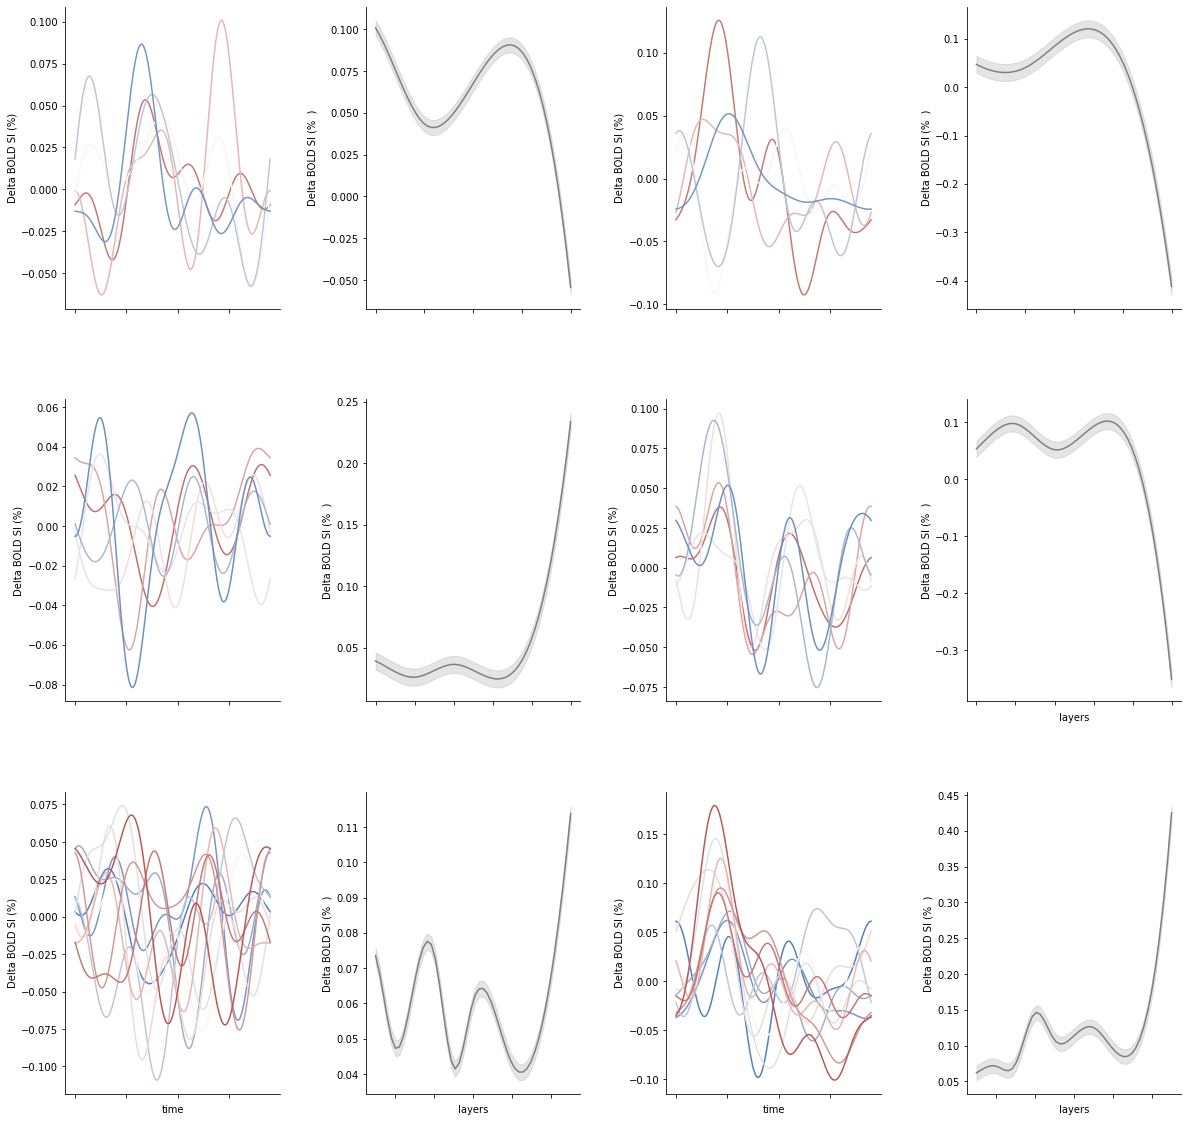

In [86]:
from colour import Color
from linescanning.bin.utils.utils import get_linerange
import seaborn as sns

orient = ['wm', 'wm', 'pial']
hemi = 'left'
black = Color("#808080")
white = Color("red")

fig = plt.figure(figsize=(20,20))
gs1 = gridspec.GridSpec(len(run_subjects),4)
gs1.update(wspace=0.4, hspace=0.3) # set the spacing between axes.
subj = g_model.get_subjectwise_timecourses()

step = 0

for sub in range(1,len(run_subjects)+1):

    #---------------------------------------------------------------------------------------------------------------------------------------------
    # This stuff calculates the voxels of the line that cover the cortical band based on the thickness created with pycortex
    # If that doesn't succeed it defaults to [355,360]
    try:
        info_file = os.path.join(base_dir, 'derivatives', 'pycortex', f'sub-00{sub}', 'line_pycortex.csv')
        try:
            from linescanning.bin.utils.utils import get_composite
            info_df = get_composite(info_file)
        except:
            raise FileNotFoundError

        info_df = info_df.reset_index()
        vert = int(info_df[(info_df['hemi'] == hemi) & (info_df['parameter'] == "vertex")]['value'].values)

        r = get_linerange(os.path.join(base_dir, 'derivatives', 'pycortex', f'sub-00{sub}', 'surface-info', 'thickness.npz'), hemi, vert, orient[sub-1])
    except:
        r = [355, 360]

    nr_vox = len(np.arange(r[0],r[1]+1,1))
    colors = sns.color_palette('vlag', nr_vox)

    # invert gradient if orient == pial
    if orient[sub-1] == "wm":
        colors.reverse()

    print(f"  {nr_vox} voxels cover the cortical band")

    #---------------------------------------------------------------------------------------------------------------------------------------------
    # Loop through the dataframe    
    tmp = subj.reset_index()
    tmp = tmp[(tmp['subject'] == sub)]
    # subj_001 = subj_001 = subj.reset_index()
    tmp = tmp.set_index(['subject', 'event type', 'covariate', 'time'])

    
    for i in ['left', 'right']:
        vox_nr = 0
        g = fig.add_subplot(gs1[step])
        max = []
        for x in np.arange(r[0],r[1]+1,1):
            tmp.droplevel([0]).iloc[:, x][i].plot(fig=g, sharex=True, color=colors[vox_nr])
            format_graph('time', 'Delta BOLD SI (%)', axis=False, leg=False, box=False, title=None, out=None)
            vox_nr += 1

            max.append(np.amax(tmp.droplevel([0]).iloc[:, x][i]))
        
        
        g.axes.xaxis.set_ticklabels([])

        step += 1

        a = fig.add_subplot(gs1[step])
        from scipy.interpolate import make_interp_spline
        from scipy.stats import sem
        from linescanning.bin.utils.utils import errorfill

        x_new = np.linspace(1,nr_vox,50)
        a_BSpline = make_interp_spline(list(np.arange(0,nr_vox,1)),max)
        y_new = a_BSpline(x_new)
        err = sem(y_new)
        # a.plot(x_new, y_new)
        errorfill(x_new, y_new, err, color='#808080', alpha_fill=0.2, ax=a)

        format_graph('layers', 'Delta BOLD SI (%  )', axis=False, leg=False, box=False, title=None, out=None)
        a.axes.xaxis.set_ticklabels([])
        step += 1
        

# fig.axes.get_xaxis().set_ticks([])
# plt.savefig(os.path.join(base_dir, 'code', 'figures', 'hrfs', 'hrf_and_timecourses_and_maxampl_singlesub.png'), transparent=True)


In [85]:
import seaborn as sns
palette = sns.color_palette('vlag', 9)
palette[0]

(0.35551826, 0.51744353, 0.73994642)

# Modular pipeline

## General settings

In [1]:
import os, json, pickle, sys
import nibabel as nb
from sklearn.preprocessing import normalize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# import hrf_estimation
import scipy.signal as signal
import scipy.stats as ss
import scipy.ndimage as ndimage

from joblib import Parallel, delayed

import nideconv as nd
import scipy.io as io
import csv

In [18]:
loc = "win" # or lin
if loc == "win":
    base_dir = "D:\FSL\shared\spinoza\projects\ANAT_SEG-Raw"
elif loc == "lin":
    base_dir = "/mnt/hgfs/shared/spinoza/projects/ANAT_SEG-Raw/"


# "runs_nodrift20200214.mat"
subject = 'sub-001'
run_subjects = ['001']
session = "ses-2"

TR = 0.105
deleted_first_timepoints = 38
initial_deleted_time = TR * deleted_first_timepoints

# Sample rate and desired cutoff frequencies (in Hz).
fs = 1/TR

hp=0.01
lp=8.0
butter_order = 3

## Behavioral data

In [529]:
df_list = [os.path.join(base_dir, subject, session, 'func', f) for f in os.listdir(os.path.join(base_dir, subject, session, 'func')) if f.endswith('.tsv')]

# get nr of runs based on the amount of files we have
runs = len(df_list)

df_data = []
for d in df_list:
    with open(d) as f:
        df = pd.read_csv(f, delimiter='\t')
        df_data.append(df)


In [530]:
# df_data[1].head(10)
df_data

[     trial_nr        onset event_type  phase response  nr_frames condition  \
 0           0     0.076342       stim      0      NaN      222.0       NaN   
 1           0     1.915159   response      0    space        NaN       NaN   
 2           1     1.923553       stim      0      NaN   123051.0       NaN   
 3           1    86.129015   response      0        e        NaN       NaN   
 4           1    90.149742   response      0        e        NaN       NaN   
 ..        ...          ...        ...    ...      ...        ...       ...   
 140        41  1314.599995   response      0        b        NaN     right   
 141        41  1318.966691       stim      1      NaN       90.0     right   
 142        42  1319.716816       stim      0      NaN     5760.0       NaN   
 143        42  1329.775548      pulse      0        t        NaN       NaN   
 144        42  1348.676171      pulse      0        t        NaN       NaN   
 
      fix_color_changetime    onset_abs     durati

In [531]:
start_times = [pd.DataFrame(df_data[i][(df_data[i]['response'] == 't') & (df_data[i]['trial_nr'] == 1) & (df_data[i]['phase'] == 0)][['onset']]).reset_index(drop=True) for i in range(0,runs)]
start_times

[         onset
 0  1027.375333,
        onset
 0  84.412746,
        onset
 0  27.703712,
        onset
 0  31.487615,
        onset
 0  25.380224]

In [532]:
# Get the onset times and normalize to zero by subtracting the start time from the onset times
onset_times = [np.array(pd.DataFrame(df_data[i][(df_data[i]['event_type'] == 'stim') & (df_data[i]['condition'].notnull())][['onset', 'condition']]['onset'] - float(start_times[i]['onset'])).reset_index(drop=True)) for i in range(0,runs)]
onset_times[0][0:5]

array([[27.66446481],
       [40.4730712 ],
       [46.94818947],
       [60.38213374],
       [70.04922826]])

In [533]:
# Get the conditions
condition = [np.array(pd.DataFrame(df_data[i][(df_data[i]['event_type'] == 'stim') & (df_data[i]['condition'].notnull())]['condition']).reset_index(drop=True)) for i in range(0,runs)]
condition[0][0:5]

array([['left'],
       ['right'],
       ['left'],
       ['left'],
       ['right']], dtype=object)

In [534]:
# Add condition to the corrected onset times
onset = [np.concatenate((onset_times[i], condition[0]), axis=1) for i in range(0, runs)]
onset[0][-1][0]
# print(onset)

291.59135812099976

## Timeseries "Preprocessing"

In [535]:
def _butter_lowpass(data, highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='lowpass')
    y = signal.filtfilt(b, a, data)
    return y

def _butter_highpass(data, lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='highpass')
    y = signal.filtfilt(b, a, data)
    return y

def _butter_bandpass(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    data_hp = _butter_highpass(data, lowcut, fs, order)
    b, a = signal.butter(order, high, btype='lowpass')
    y = signal.filtfilt(b, a, data_hp)
    return y

In [536]:
# Load in datasets with tag "wcsmtSNR"
ts_wcsmtSNR = [io.loadmat(os.path.join(base_dir, subject, session, 'func', f'{subject}_{session}_run-{i}_task-hemifield_bold'))['Data_wcsmtSNR_ecomb'] for i in range(1,(runs+1))]
print(ts_wcsmtSNR[0].shape)
ts_complex = [ts_wcsmtSNR[i] for i in range(0,runs)]
ts_magnitude = [np.abs(ts_wcsmtSNR[i]) for i in range(0,runs)]

(720, 3240)


In [537]:
# cut off nothingness at the end
ts_corrected = []
for i, rd in enumerate(ts_magnitude):
    size_red = int(np.round(onset_times[i][-1][0] * fs))
    ts_corrected.append(rd[:,:size_red])
    print(" run " + str(i+1) + " now has " + str(size_red) + " volumes")
    print(onset_times[i][-1][0])

    # corrected_run_data.append(rd[:,:int(np.round(stim_times[i][-1] * fs))])

 run 1 now has 2777 volumes
291.59135812099976
 run 2 now has 2779 volumes
291.8453413540001
 run 3 now has 2793 volumes
293.30946163799945
 run 4 now has 2802 volumes
294.25251531199956
 run 5 now has 2792 volumes
293.1928292319999


In [538]:
# just doing z-scoring now.
z_run_data = [(rd-rd.mean(-1)[:,np.newaxis]) / rd.std(1)[:,np.newaxis] for rd in ts_corrected]
print(rd)
# or percent signal change?
z_run_data = [100*(rd-rd.mean(-1)[:,np.newaxis]) / rd.mean(1)[:,np.newaxis] for rd in ts_corrected]

vox_cols = [f'vox {x}' for x in range(z_run_data[i].shape[0])]
# z_run_data[0].shape[-1]

[[8.82220389 7.66711038 6.97792847 ... 7.03106528 7.60104236 6.74249275]
 [6.64121353 5.77522866 6.31179987 ... 7.13693161 8.70549323 8.36390802]
 [6.81216042 6.19040789 5.68319411 ... 6.57151884 7.82699286 5.27142726]
 ...
 [4.55603274 4.25689343 7.31618033 ... 5.74081165 4.76631829 5.13282959]
 [4.22806314 7.22052953 4.25052715 ... 6.07921534 5.1709707  7.56645406]
 [4.45297651 6.29427764 6.29429842 ... 6.11031988 6.15462983 7.85248412]]


## Model Fitting

In [539]:
z_run_data[0].T

array([[ 12.03716953, -20.77613889, -16.04085736, ...,  17.23537693,
        -23.79686275,  17.29840715],
       [-33.34927631,  -4.42975985,   6.60757611, ...,  40.30209031,
         -7.02156532,   3.99848999],
       [-14.54177331,  -5.088741  ,  13.12354737, ...,   1.15297528,
         18.18013821,  12.38478657],
       ...,
       [-17.85732392, -23.31059403,  31.92798314, ..., -15.32010752,
        -14.57426316, -21.34580392],
       [-28.97069644,   2.47830657,  18.14929431, ..., -11.35515417,
        -20.05649915,  12.99079222],
       [ 18.85143113,  26.9450112 ,  21.77620364, ..., -43.68587454,
         -4.79128534, -21.62344076]])

In [540]:
mixed_data = pd.concat([pd.DataFrame(z_run_data[i].T,
                    index=pd.MultiIndex.from_product(
                        [[i+1],
                        list(TR*np.arange(z_run_data[i].shape[-1]))], names=['run', 't']),
                    columns=vox_cols) for i in range(len(z_run_data))])
mixed_data.head()

mixed_onsets = pd.concat([pd.DataFrame(onset[i], columns=['onset', 'event_type']) for i in np.arange(len(onset))], keys=np.arange(len(onset))+1, names=['run'])
print(mixed_onsets.head(5))
print(mixed_data.head(5))


         onset event_type
run                      
1   0  27.6645       left
    1  40.4731      right
    2  46.9482       left
    3  60.3821       left
    4  70.0492      right
               vox 0      vox 1      vox 2      vox 3      vox 4      vox 5  \
run t                                                                         
1   0.000  12.037170 -20.776139 -16.040857 -14.656934  -3.646084 -27.895219   
    0.105 -33.349276  -4.429760   6.607576  -1.157403  20.455682  13.140607   
    0.210 -14.541773  -5.088741  13.123547   4.390495   3.892098 -44.876335   
    0.315   6.762691 -14.298697 -16.338743 -15.997174   7.709424 -21.709681   
    0.420  11.486664   8.121925 -28.411632  20.477936   5.421896 -45.502136   

               vox 6      vox 7      vox 8      vox 9  ...    vox 710  \
run t                                                  ...              
1   0.000   5.140143  22.752489  13.051425 -17.103195  ...  -7.167881   
    0.105   7.097402   4.732502   7.182290   

In [541]:
mixed_onsets2 = pd.concat([pd.DataFrame(onset[i], columns=['onset', 'event_type']) for i in np.arange(len(onset))], keys=np.arange(len(onset))+1, names=['run'])
mixed_onsets2.reset_index(level=0, inplace=True)
mixed_onsets2['subject'] = sub_idx
mixed_onsets2.set_index(['subject', 'run', 'event_type'])

onset
subject run event_type         
1       1   left        27.6645
            right       40.4731
            left        46.9482
            left        60.3821
            right       70.0492
...                         ...
        5   right       266.576
            right       276.967
            left        283.976
            left        288.718
            right       293.193

[200 rows x 1 columns]

In [542]:
mixed_data2 = pd.concat([pd.DataFrame(z_run_data[i].T,
                    index=pd.MultiIndex.from_product(
                        [[i+1],
                        list(TR*np.arange(z_run_data[i].shape[-1]))], names=['run', 't']),
                    columns=vox_cols) for i in range(len(z_run_data))])

mixed_data2.reset_index(inplace=True)
mixed_data2['subject'] = sub_idx
mixed_data2.set_index(['subject', 'run', 't'])

vox 0      vox 1      vox 2      vox 3      vox 4  \
subject run t                                                                
1       1   0.000    12.037170 -20.776139 -16.040857 -14.656934  -3.646084   
            0.105   -33.349276  -4.429760   6.607576  -1.157403  20.455682   
            0.210   -14.541773  -5.088741  13.123547   4.390495   3.892098   
            0.315     6.762691 -14.298697 -16.338743 -15.997174   7.709424   
            0.420    11.486664   8.121925 -28.411632  20.477936   5.421896   
...                        ...        ...        ...        ...        ...   
        5   292.635  -1.629149  34.323707 -16.492129 -17.406894  34.389951   
            292.740  -5.780825 -10.182895  -0.163295 -15.857763   6.257998   
            292.845  27.208026   7.008027 -10.761139  -4.173426  29.584066   
            292.950 -32.587899   4.513745 -21.518708 -26.903749   7.428764   
            293.055   1.166686  -6.686760  -3.551765 -26.078271   1.099677   

                         vox 5      vox 6      vox 7      vox 8      vox 9  \
subject run t                                                                
1       1   0.000   -27.895219   5.140143  22.752489  13.051425 -17.103195   
            0.105    13.140607   7.097402   4.732502   7.182290   4.608616   
            0.210   -44.876335   5.761639 -13.169005  11.762264  30.986023   
            0.315   -21.709681 -20.289004  13.832586  25.841149   0.252718   
            0.420   -45.502136  32.066324 -18.619793  22.091550  -2.374777   
...                        ...        ...        ...        ...        ...   
        5   292.635  31.597399  -0.162383   0.703038  13.052585   6.823547   
            292.740 -18.474283  -3.502150   5.414937 -23.723168 -31.986104   
            292.845 -10.300768 -31.968583   8.375278  -2.522753   5.123685   
            292.950  12.851907  -9.938510 -31.749462  -5.376735 -17.675805   
            293.055   5.280766 -27.297382 -16.518571 -17.112839  23.633705   

                     ...    vox 710    vox 711    vox 712    vox 713  \
subject run t        ...                                               
1       1   0.000    ...  -7.167881   9.157225   2.990241  25.523780   
            0.105    ... -15.132961 -16.591560  28.814834  32.538547   
            0.210    ...  -6.905733  10.914182  50.876615   6.243145   
            0.315    ...   4.287523 -14.327545  -1.182947   6.045366   
            0.420    ... -36.808898  10.018377   0.976593  18.604885   
...                  ...        ...        ...        ...        ...   
        5   292.635  ...  14.204569 -19.302466  10.690130 -12.589330   
            292.740  ...  -6.312853  35.062116   4.945125   5.870192   
            292.845  ...   6.238841  13.416472  -5.073715 -14.264264   
            292.950  ...   5.598660 -25.982618   5.667755 -27.768638   
            293.055  ...   3.072492 -24.610029  -0.378732  -7.119377   

                       vox 714    vox 715    vox 716    vox 717    vox 718  \
subject run t                                                                
1       1   0.000    25.916580   4.468426   1.024383  17.235377 -23.796863   
            0.105   -34.987117 -14.910356 -13.275625  40.302090  -7.021565   
            0.210    13.292177  12.339427   6.438588   1.152975  18.180138   
            0.315     7.312306 -20.634297   1.759863  -1.350363  -0.127642   
            0.420   -29.720840 -11.803504   9.690098  16.976267 -36.664882   
...                        ...        ...        ...        ...        ...   
        5   292.635  -0.434502  28.360528  43.062932  19.693424  16.325599   
            292.740 -20.358108  20.217598 -18.324701  15.536402  17.899604   
            292.845 -32.677830  10.675889 -28.335075  -2.688242  15.082064   
            292.950 -21.088170   2.692062  37.071645  -2.157969  21.476103   
            293.055 -23.517284 -14.040309  21.170916 -17.336443 -21.833320   

                       vox 719  
subject ru

In [9]:
# model without physiology regressors
g_model = nd.GroupResponseFitter(mixed_data,
                                 mixed_onsets,
                                 input_sample_rate=1.0/TR,
                                 concatenate_runs=True,
                                 oversample_design_matrix=1,
                                 confounds=None, add_intercept=False)

g_model.add_event('left',
                  basis_set='fourier',
                  n_regressors=9,
                  interval=[0, 40*TR])

g_model.add_event('right',
                  basis_set='fourier',
                  n_regressors=9,
                  interval=[0, 40*TR])

g_model.fit()

NameError: name 'mixed_data' is not defined

### Test with dataframe indexed to subject

In [545]:
# model without physiology regressors
g_model2 = nd.GroupResponseFitter(mixed_data2,
                                 mixed_onsets2,
                                 input_sample_rate=1.0/TR,
                                 concatenate_runs=True,
                                 oversample_design_matrix=1,
                                 confounds=None, add_intercept=False)

g_model2.add_event('left',
                  basis_set='fourier',
                  n_regressors=10,
                  interval=[0, 40*TR])

g_model2.add_event('right',
                  basis_set='fourier',
                  n_regressors=10,
                  interval=[0, 40*TR])

g_model2.fit()

## Results

In [8]:
# Define function to do some formatting for us
def format_graph(X,Y,axis,title,leg,box,out):

    """
    Function that formats the graphs. Takes the following arguments:
        - Label for X axis (str) > give name for x-axis
        - Label for Y axis (str) > give name for y-axis
        - Axis (False/True)      > draw axis lines or not
        - Title (if yes, str)    > title of figure
        - Legend (False/True)    > show legend or not
        - Box (False/True)       > draw box around legend or not
        - Out (str)              > save as str()
    """

    # Define axis names
    if X != None:
        plt.gca().set_xlabel(X)
    if Y != None:
        plt.gca().set_ylabel(Y)

    # Only draw x/y axis (not the full box)
    if axis == False:
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

    if title == None:
        pass
    elif title != "":
        plt.title(title)

    # Draw legend
    if leg == True:
        plt.legend()

        if box == False:
            plt.legend(frameon=False)

    # Save or not
    if out != None:
        plt.savefig(out)

### R-squared distribution

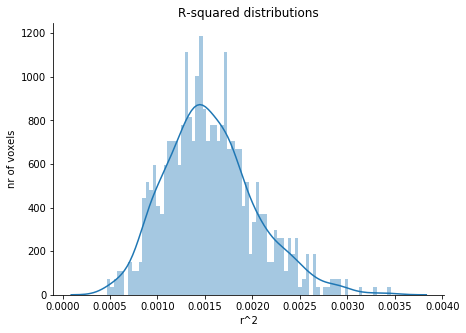

In [11]:
plt.figure(figsize=(7,5))
sns.distplot(g_model.get_rsq(),
            label='0 model',
            bins=80)

format_graph('r^2',
            'nr of voxels',
            axis=False,
            leg=False,
            box=False,
            title='R-squared distributions',
            out=None)

In [12]:
# g_model.get_conditionwise_timecourses().iloc[0:len(onset[0])]

Text(0.5, 1.0, 'Left hemi')

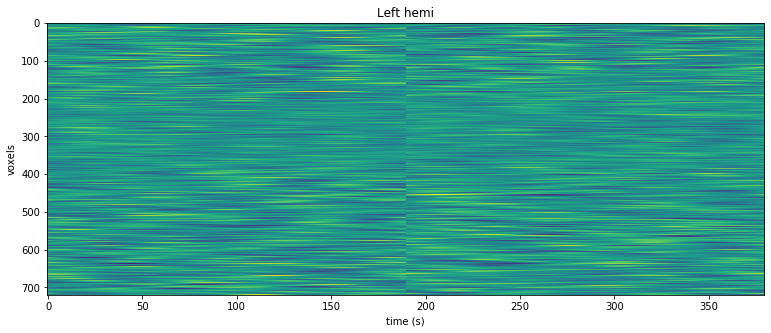

In [141]:
fig = plt.figure(figsize=(20,5))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=-0.5, hspace=0) # set the spacing between axes.

ax1 = fig.add_subplot(gs1[0])
plt.imshow(g_model.get_conditionwise_timecourses().T, aspect=1/5) # , clim=[-0.01,0.01]
ax1.autoscale(True)
ax1.set_xlabel('time (s)')
ax1.set_ylabel('voxels')
ax1.set_title('Left hemi')

# ax2 = fig.add_subplot(gs1[1])
# ax2.imshow(g_model.get_conditionwise_timecourses().iloc[len(onset[0]):].T, aspect=1/20)
# ax2.autoscale(True)
# ax2.set_xlabel('time (s)')
# ax2.set_title('Right hemi')

### Hemodynamic response functions (HRFs)

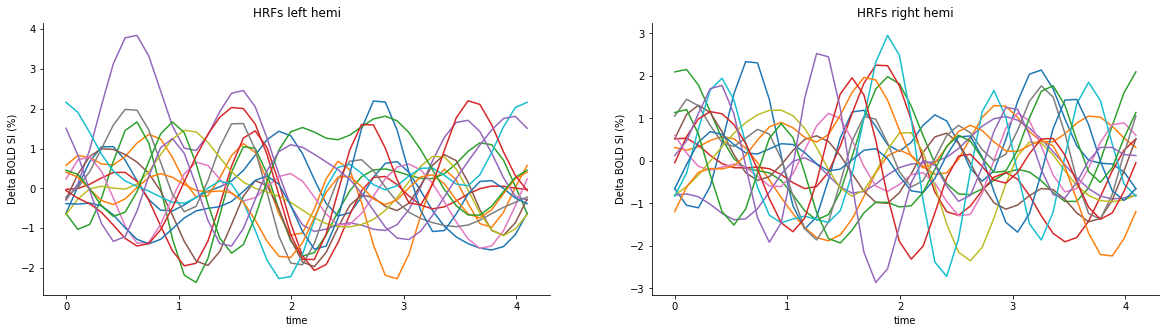

In [19]:
fig = plt.figure(figsize=(20,5))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.2, hspace=0) # set the spacing between axes.

g = fig.add_subplot(gs1[0])
step = 0
for x in np.arange(595,610,1):
    g_model.get_conditionwise_timecourses().iloc[:, x]['left'].droplevel([0]).plot(fig=g)
    format_graph('time', 'Delta BOLD SI (%)', axis=False, leg=False, box=False, title='HRFs left hemi', out=None)

g = fig.add_subplot(gs1[1])
step = 0
for x in np.arange(595,610,1):
    g_model.get_conditionwise_timecourses().iloc[:, x]['right'].droplevel([0]).plot(fig=g)
    format_graph('time', 'Delta BOLD SI (%)', axis=False, leg=False, box=False, title='HRFs right hemi', out=None)